In [26]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the dataset dir
train_dir = "/kaggle/input/hand-gesture-recognition-dataset/train/train"
test_dir = "/kaggle/input/hand-gesture-recognition-dataset/test/test"

# Function to load the dataset paths and labels
def load_data(directory):
    X = []
    y = []
    for class_dir in os.scandir(directory):
        if class_dir.is_dir():
            class_label = class_dir.name  # Class labels are folder names (0-19) as strings
            for img_file in os.scandir(class_dir.path):
                if img_file.name.endswith(('.png', '.jpg', '.jpeg')):
                    X.append(img_file.path)
                    y.append(class_label)
    return np.array(X), np.array(y)

# Loading original training data ,which is split into new train and test
X_train_full, y_train_full = load_data(train_dir)

# Split the training data: 80% for training and 20% for new testing
X_train, X_test_new, y_train, y_test_new = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0, stratify=y_train_full)

# Loading the original test data, which will be used as validation set now
X_val, y_val = load_data(test_dir)

# shapes of the splits
print(f"Original training data size: {X_train_full.shape[0]}")
print(f"New training set size: {X_train.shape[0]}")
print(f"New test set size: {X_test_new.shape[0]}")
print(f"Validation set (original test) size: {X_val.shape[0]}")

# Now we use ImageDataGenerator for data augmentation on train set 
train_datagen = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": X_train, "class": y_train}),
    x_col='filename',
    y_col='class',
    target_size=(50, 50),  # Resize the images if needed
    color_mode='grayscale',  # Since images are black and white
    class_mode='sparse',  # Labels are now strings, so sparse should work
    batch_size=32,
    shuffle=True
)

# Test generator ,new test set, spliting from the original training data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": X_test_new, "class": y_test_new}),
    x_col='filename',
    y_col='class',
    target_size=(50, 50),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)

# Validation generator ,this is the original test set
val_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": X_val, "class": y_val}),
    x_col='filename',
    y_col='class',
    target_size=(50, 50),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)



Original training data size: 18000
New training set size: 14400
New test set size: 3600
Validation set (original test) size: 6000
Found 14400 validated image filenames belonging to 20 classes.
Found 3600 validated image filenames belonging to 20 classes.
Found 6000 validated image filenames belonging to 20 classes.


In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# No. of classes (0-19)
num_classes = 20  

# Building a model
model = tf.keras.Sequential([

    # First convolutional layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 1)),  
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  

    # Second convolutional layer 
    Conv2D(16, (3, 3), activation='relu'), 
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  

    # Flattening the output from the conv layers
    Flatten(),

    # Fully connected layer
    Dense(64, activation='relu'),  
    BatchNormalization(),
    Dropout(0.4), 

    # Output layer with softmax for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Displays the model architecture
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
batch_normalization_38 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 22, 22, 16)        2320      
_________________________________________________________________
batch_normalization_39 (Batc (None, 22, 22, 16)        64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 11, 11, 16)      

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# to compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a lr of 0.001
    loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

# Setting early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with the training set and validate using the validation set which is the original test set
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=5,  # No of epochs
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1  # to track the training progress
)



Epoch 1/5
450/450 [==============================] - 29s 63ms/step - loss: 0.5250 - accuracy: 0.8631 - val_loss: 0.2873 - val_accuracy: 0.9755
Epoch 2/5
450/450 [==============================] - 28s 63ms/step - loss: 0.0933 - accuracy: 0.9815 - val_loss: 0.0057 - val_accuracy: 0.9997
Epoch 3/5
450/450 [==============================] - 29s 65ms/step - loss: 0.0544 - accuracy: 0.9888 - val_loss: 0.0092 - val_accuracy: 0.9972
Epoch 4/5
450/450 [==============================] - 29s 65ms/step - loss: 0.0369 - accuracy: 0.9919 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 5/5
450/450 [==============================] - 30s 66ms/step - loss: 0.0277 - accuracy: 0.9939 - val_loss: 0.0025 - val_accuracy: 0.9997


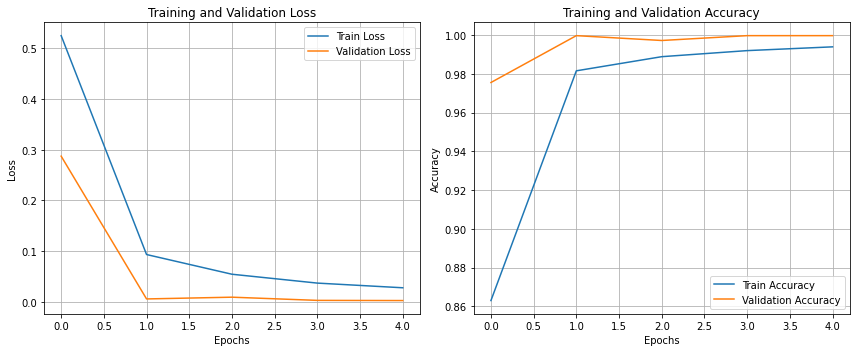

113/113 [==============================] - 4s 34ms/step - loss: 8.7043e-04 - accuracy: 0.9997
Test Accuracy: 99.97%
Test Loss: 0.0009


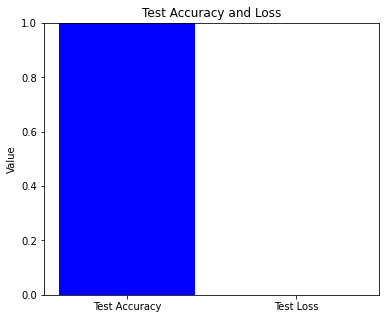

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluating the model on the test set and plotting the test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_generator)

# Printing test accuracy and loss
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plotting the test accuracy and loss (single points)
plt.figure(figsize=(6, 5))
plt.bar(['Test Accuracy', 'Test Loss'], [test_accuracy, test_loss], color=['blue', 'orange'])
plt.title('Test Accuracy and Loss')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       180
          10       1.00      1.00      1.00       180
          11       0.99      1.00      1.00       180
          12       1.00      1.00      1.00       180
          13       1.00      1.00      1.00       180
          14       1.00      0.99      1.00       180
          15       1.00      1.00      1.00       180
          16       1.00      1.00      1.00       180
          17       1.00      1.00      1.00       180
          18       1.00      1.00      1.00       180
          19       1.00      1.00      1.00       180
           2       1.00      1.00      1.00       180
           3       1.00      1.00      1.00       180
           4       1.00      1.00      1.00       180
           5       1.00      1.00      1.00       180
           6       1.00      1.00      1.00       180
   

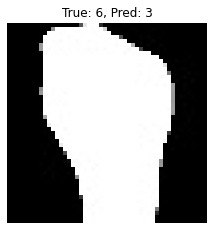

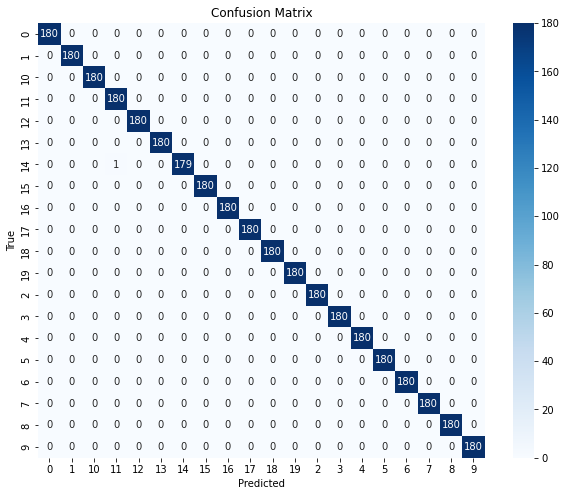

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels
true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Identify misclassifications
misclassified_idx = np.where(pred_labels != true_labels)[0]

# Print classification report (precision, recall, f1-score)
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=list(test_generator.class_indices.keys())))

# Load images and labels from the generator to match with misclassified indices
def get_images_and_labels(generator):
    images, labels = [], []
    for i in range(len(generator)):
        img_batch, label_batch = generator[i]
        for img, label in zip(img_batch, label_batch):
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Fetch all images and labels from test generator
images, labels = get_images_and_labels(test_generator)

# Function to visualize misclassified images
def visualize_misclassified(misclassified_idx, images, pred_labels, true_labels, num_images=10):
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(misclassified_idx[:num_images]):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[idx].reshape(50, 50), cmap='gray')
        plt.title(f"True: {true_labels[idx]}, Pred: {pred_labels[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some of the misclassified images
visualize_misclassified(misclassified_idx, images, pred_labels, true_labels, num_images=9)

# Print and visualize confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_generator.class_indices.keys()), 
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
